In [1]:
import os
import gzip
import pickle
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import watchcbb.utils as utils
import watchcbb.efficiency as eff
from watchcbb.sql import SQLEngine

### Load individual game data

In [3]:
sql = SQLEngine('cbb')
df_games = sql.df_from_query(""" SELECT * FROM game_data ORDER BY "Date" """)
df_games.tail(10)

,Season,Date,gid,Type,WTeamID,WScore,LTeamID,LScore,Wrank,Lrank,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,poss
54750,2020,2020-03-11,2020-03-11_minnesota_northwestern,CT,minnesota,74,northwestern,57,-1,-1,...,6,8,4,24,11,8,2,7,11,63.40
54751,2020,2020-03-11,2020-03-11_kansas-state_texas-christian,CT,kansas-state,53,texas-christian,49,-1,-1,...,3,4,4,23,12,14,8,7,11,63.14
54752,2020,2020-03-11,2020-03-11_manhattan_siena,CT,siena,63,manhattan,49,-1,-1,...,5,10,11,21,7,9,4,4,14,61.90
54753,2020,2020-03-11,2020-03-11_oregon-state_utah,CT,oregon-state,71,utah,69,-1,-1,...,8,13,12,17,13,16,4,0,16,61.66
54754,2020,2020-03-11,2020-03-11_georgia_mississippi,CT,georgia,81,mississippi,63,-1,-1,...,11,17,9,21,6,15,5,2,19,71.14
54755,2020,2020-03-11,2020-03-11_depaul_xavier,CT,depaul,71,xavier,67,-1,-1,...,10,14,5,21,14,11,10,1,14,69.54
54756,2020,2020-03-11,2020-03-11_george-mason_saint-josephs,CT,george-mason,77,saint-josephs,70,-1,-1,...,8,14,5,19,11,6,6,3,21,71.24
54757,2020,2020-03-11,2020-03-11_iowa-state_oklahoma-state,CT,oklahoma-state,72,iowa-state,71,-1,-1,...,8,9,10,22,7,15,5,2,19,69.32
54758,2020,2020-03-11,2020-03-11_alabama-birmingham_texas-san-antonio,CT,alabama-birmingham,74,texas-san-antonio,69,-1,-1,...,7,7,12,20,11,12,4,2,17,69.44
54759,2020,2020-03-11,2020-03-11_florida-atlantic_old-dominion,CT,florida-atlantic,66,old-dominion,56,-1,-1,...,10,12,9,25,9,22,6,1,14,65.06


### Compute full season stats
Cache it into a pickle so we don't waste time recomputing each time

In [4]:
fname = 'cached/preseason_nb_season_stats.pkl.gz'
if os.path.exists(fname):
    with gzip.open(fname, 'rb') as fid:
        season_stats_df, season_stats_dict = pickle.load(fid)
else:
    season_stats_dict = utils.compute_season_stats(df_games)
    season_stats_df = utils.stats_dict_to_df(season_stats_dict)
    utils.add_advanced_stats(season_stats_df)
    season_stats_dict = utils.stats_df_to_dict(season_stats_df)
    eff.compute_efficiency_ratings(season_stats_dict)
    season_stats_df = utils.stats_dict_to_df(season_stats_dict)
    os.makedirs(os.path.dirname(fname), exist_ok=True)
    with gzip.open(fname, 'wb') as fid:
        pickle.dump((season_stats_df, season_stats_dict), fid)

print(season_stats_df.shape)
season_stats_df[['year','team_id','wins','losses','Tneteff']].head()

(3497, 81)


,year,team_id,wins,losses,Tneteff
0,2011,air-force,15,15,5.814456
1,2011,akron,22,13,3.769233
2,2011,alabama,25,12,15.892420
3,2011,alabama-am,10,15,-16.968670
4,2011,alabama-birmingham,22,9,13.027349


In [7]:
PREDICT_YEAR = 2021
years = season_stats_df.year.unique().tolist()
if PREDICT_YEAR is not None:
    years.append(PREDICT_YEAR)

## Get roster info
The player IDs of each player on each team/year

In [8]:
class Player():
    def __init__(self, ws=0, mp=0, exp=0):
        self.ws = ws
        self.mp = mp
        self.exp = exp

# dict to hold the cumulative #years of experience for each player
player_exp = defaultdict(int)
# dict to hold player info used later
player_dict = {}
for year in years:
# for year in [2020]:
    player_dict[year] = {}
    roster_df = pd.read_pickle(f'../data/rosters/{year}.pkl.gz', compression='gzip').reset_index(drop=True)
    if year not in season_stats_dict:
        season_stats_dict[year] = defaultdict(dict)
    for irow,row in roster_df.iterrows():
        season_stats_dict[year][row.team_id]['players'] = row.players
        season_stats_dict[year][row.team_id]['player_WS'] = row.WS
        season_stats_dict[year][row.team_id]['player_MP'] = row.MP
        for i,pid in enumerate(row.players):
            player_exp[pid] += 1
            if pid not in player_dict[year]:
                player_dict[year][pid] = Player(ws=row.WS[i], mp=row.MP[i], exp=player_exp[pid])

In [10]:
season_stats_dict[2021]['purdue']['players']

['carson-barrett-1',
 'emmanuel-dowuona-1',
 'zach-edey-1',
 'matt-frost-1',
 'mason-gillis-1',
 'eric-hunterjr-1',
 'jaden-ivey-1',
 'chase-martin-1',
 'ethan-morton-1',
 'brandon-newman-2',
 'sasha-stefanovic-1',
 'isaiah-thompson-1',
 'aaron-wheeler-2',
 'trevion-williams-1',
 'jared-wulbrun-1']

## Get recruiting rankings

In [11]:
for year in years:
    df_espn = pd.read_csv(f'../data/recruit_ranks/espn_{year-1}.csv')
    df_rsci = pd.read_csv(f'../data/recruit_ranks/rsci_{year-1}.csv')
    for irow,row in df_espn.iterrows():
        season_stats_dict[year][row.team_id]['espn_recruit_rank'] = row.Rank
    for irow,row in df_rsci.iterrows():
        season_stats_dict[year][row.team_id]['rsci_recruit_rank'] = row.Rank
        season_stats_dict[year][row.team_id]['rsci_recruit_points'] = row.points
season_stats_dict[2018]['purdue']['rsci_recruit_points']

34

## Get win-shares lost each year

In [ ]:
for year in years:
    if year-1 not in season_stats_dict:
        continue
    for tid in season_stats_dict[year]:
        if tid not in season_stats_dict[year-1]:
            continue
        if 'players' not in season_stats_dict[year][tid] or 'players' not in season_stats_dict[year-1][tid]:
            continue
        old_players = season_stats_dict[year-1][tid]["players"]
        new_players = season_stats_dict[year][tid]["players"]
        wshares = season_stats_dict[year-1][tid]["player_WS"]
        wshares_lost = 0.0
        wshares_return = 0.0
        wshares_transfer = 0.0
        for pid, ws in zip(old_players, wshares):
            if pid not in new_players:
                wshares_lost += ws
            else:
                wshares_return += ws
        
        ## very rough accounting for transfers:
        for pid in new_players:
            ## these players are probably grad transfers
            if pid not in old_players and pid in player_dict[year-1] and player_dict[year-1][pid].exp >= 3:
                wshares_transfer += player_dict[year-1][pid].ws
            ## these are probably non-grad transfers that have to sit out
            elif pid not in old_players and pid in player_dict[year-1] and player_dict[year-1][pid].exp > 0:
                pass
            ## the next two cover players that sat out for transfer/injury/etc and come back
            elif pid not in old_players and year-2 in player_dict and pid in player_dict[year-2]:
                wshares_transfer += player_dict[year-2][pid].ws
            elif pid in old_players and player_dict[year-1][pid].ws == 0.0 and year-2 in player_dict and pid in player_dict[year-2]:
                wshares_transfer += player_dict[year-1][pid].ws

        season_stats_dict[year][tid]["wshares_lost"] = wshares_lost
        season_stats_dict[year][tid]["wshares_return"] = wshares_return
        season_stats_dict[year][tid]["wshares_transfer"] = wshares_transfer

In [16]:
year_start = season_stats_df.year.min() + 2
data = defaultdict(list)
for year in range(year_start, max(years)+1):
    for tid in season_stats_dict[year]:
        data['year'].append(year)
        data['tid'].append(tid)
        data['final_eff'].append(season_stats_dict[year][tid].get("Tneteff", None))
        data['yearm1_eff'].append(season_stats_dict[year-1].get(tid,{}).get("Tneteff",None))
        if tid in season_stats_dict[year-2]:
            data['yearm2_eff'].append(season_stats_dict[year-2][tid].get("Tneteff",None))
        else:
            data['yearm2_eff'].append(season_stats_dict[year-1].get(tid,{}).get("Tneteff",None))
        data['wshares_lost'].append(season_stats_dict[year][tid].get('wshares_lost',None))
        data['wshares_return'].append(season_stats_dict[year][tid].get('wshares_return',None))
        data['wshares_transfer'].append(season_stats_dict[year][tid].get('wshares_transfer',None))
        data['espn_recruit_rank'].append(season_stats_dict[year][tid].get('espn_recruit_rank',None))
        data['rsci_recruit_rank'].append(season_stats_dict[year][tid].get('rsci_recruit_rank',None))
        data['rsci_recruit_points'].append(season_stats_dict[year][tid].get('rsci_recruit_points',0))
        data['yearm1_oeff'].append(season_stats_dict[year-1].get(tid,{}).get('Tcorroeff',None))
        data['yearm1_deff'].append(season_stats_dict[year-1].get(tid,{}).get('Tcorrdeff',None))
        data['yearm1_pace'].append(season_stats_dict[year-1].get(tid,{}).get('pace',None))
        data['final_pace'].append(season_stats_dict[year][tid].get('pace',None))
        
df = pd.DataFrame(data, columns=['year','tid','final_eff','yearm1_eff', 'yearm2_eff',
                                 'wshares_lost','wshares_return','wshares_transfer',
                                 'espn_recruit_rank','rsci_recruit_rank','rsci_recruit_points',
                                 'yearm1_oeff','yearm1_deff','yearm1_pace','final_pace'])
df.loc[df.tid=='purdue']

,year,tid,final_eff,yearm1_eff,yearm2_eff,wshares_lost,wshares_return,wshares_transfer,espn_recruit_rank,rsci_recruit_rank,rsci_recruit_points,yearm1_oeff,yearm1_deff,yearm1_pace,final_pace
243,2013,purdue,10.191958,18.156229,28.141931,14.3,7.7,0.0,19.0,42.0,35,113.533807,95.377578,66.347913,68.218224
594,2014,purdue,9.686132,10.191958,18.156229,6.8,9.7,0.2,38.0,33.0,55,102.659352,92.467394,68.218224,70.065691
945,2015,purdue,17.805863,9.686132,10.191958,7.2,8.7,0.0,26.0,46.0,19,107.424494,97.738362,70.065691,65.994055
1296,2016,purdue,26.743148,17.805863,9.686132,5.8,15.8,1.4,23.0,25.0,85,109.061839,91.255976,65.994055,69.786138
1647,2017,purdue,26.661481,26.743148,17.805863,11.6,17.3,1.4,NaN,NaN,0,116.226410,89.483261,69.786138,70.844561
1998,2018,purdue,32.061396,26.661481,26.743148,8.1,19.8,0.3,NaN,40.0,34,117.593980,90.932499,70.844561,69.380092
2351,2019,purdue,30.008648,32.061396,26.661481,20.2,12.5,2.0,36.0,NaN,0,123.335106,91.273710,69.380092,67.485581
2705,2020,purdue,19.608672,30.008648,32.061396,13.8,13.7,4.9,NaN,NaN,0,123.314329,93.305681,67.485581,65.752757
3060,2021,purdue,NaN,19.608672,30.008648,9.2,11.1,0.0,NaN,36.0,30,108.020986,88.412314,65.752757,NaN


In [17]:
df = df.dropna(subset=['yearm1_eff','yearm2_eff','wshares_lost','wshares_return','wshares_transfer'])

Text(0, 0.5, 'rsci recruit points')

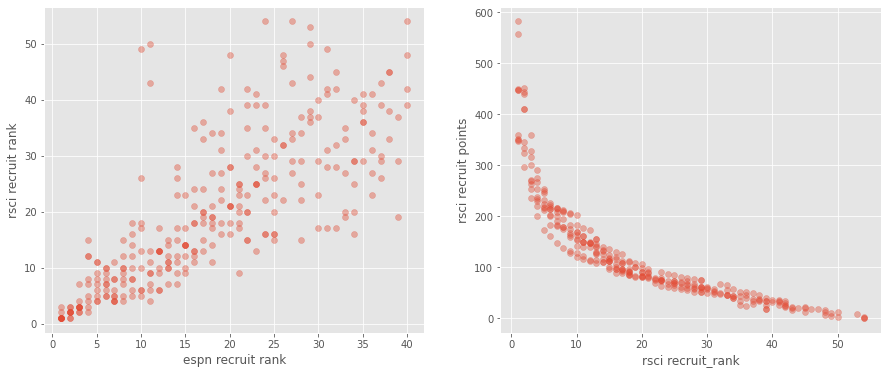

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))
dfr = df[['espn_recruit_rank','rsci_recruit_rank','rsci_recruit_points']].dropna()
axs[0].scatter(dfr.espn_recruit_rank, dfr.rsci_recruit_rank, alpha=0.4)
axs[0].set_xlabel('espn recruit rank')
axs[0].set_ylabel('rsci recruit rank')
axs[1].scatter(dfr.rsci_recruit_rank, dfr.rsci_recruit_points, alpha=0.4)
axs[1].set_xlabel('rsci recruit_rank')
axs[1].set_ylabel('rsci recruit points')

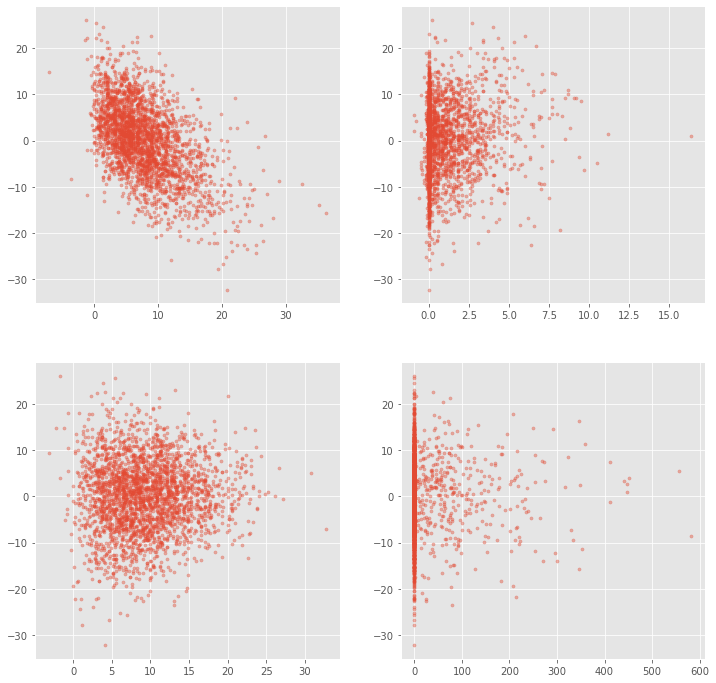

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))
axs = axs.flatten()
dfr = df[['final_eff','yearm1_eff','wshares_lost','wshares_transfer','wshares_return','rsci_recruit_points']].dropna()
for i,col in enumerate(['wshares_lost','wshares_transfer','wshares_return','rsci_recruit_points']):
    axs[i].scatter(df[col], df.final_eff-df.yearm1_eff, s=10, alpha=0.4)

linreg_baseline [0.82268595] 0.06170868892096781
linreg1 [ 0.94673117 -0.94419874  1.11090874  0.03250135] 5.782908046673398
linreg2 [ 0.82687399  0.14897761 -0.91775003  0.99860352  0.02852532] 5.74380693487221
linreg_norecruit [ 0.84088366  0.17635551 -0.88140648  1.01519792] 5.857947220793789
linreg_notransfer [ 0.81945544  0.1787115  -0.88941783  0.02916338] 6.419951255670942
linreg_nolost [0.61099945 0.19587022 0.80887683 0.01916745] -0.9332396199581622
7.45 linreg_baseline
7.12 linreg_nolost
6.31 linreg_notransfer
6.25 linreg_norecruit
6.23 linreg1
6.20 xgb2
6.14 linreg2


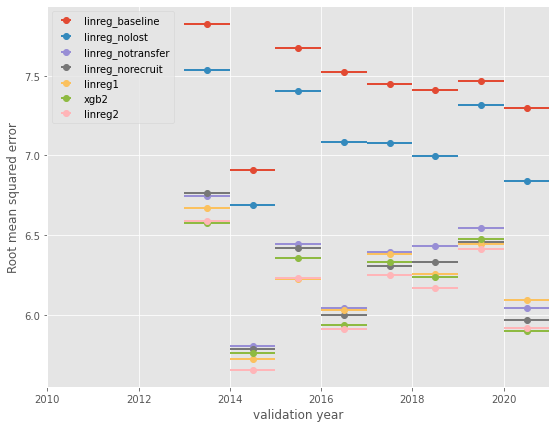

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

linreg = LinearRegression()

df['recruit_score'] = df.rsci_recruit_points
# df['recruit_score'] = df.espn_recruit_rank.fillna(100)
# df.recruit_score = 0.532/(df.recruit_score - 0.765)**0.436
# df.recruit_score = np.log10(df.recruit_score+1)

df_tmp = df[df.year != PREDICT_YEAR]

models = {
    "linreg_baseline" : ['yearm1_eff'],
    "linreg1" : ['yearm1_eff','wshares_lost','wshares_transfer','recruit_score'],
    "linreg2" : ['yearm1_eff','yearm2_eff','wshares_lost','wshares_transfer','recruit_score'],
    "linreg_norecruit" : ['yearm1_eff','yearm2_eff','wshares_lost','wshares_transfer'],
    "linreg_notransfer" : ['yearm1_eff','yearm2_eff','wshares_lost','recruit_score'],
    "linreg_nolost" : ['yearm1_eff','yearm2_eff','wshares_transfer','recruit_score'],
    "xgb2" : ['yearm1_eff','yearm2_eff','wshares_lost','wshares_transfer','recruit_score'],
}
model_scores = defaultdict(list)
years = sorted(df_tmp.year.unique())
NVALID = 1
start_years = years[:len(years)-NVALID+1:NVALID]
for start_valid in start_years:
    valid_years = list(range(start_valid, start_valid+NVALID))
    train_years = sorted(set(years)-set(valid_years))
    
    for name,cols in models.items():
        X_train = df_tmp.loc[df.year.isin(train_years)][cols]
        y_train = df_tmp.loc[df.year.isin(train_years)].final_eff
        X_valid = df_tmp.loc[df.year.isin(valid_years)][cols]
        y_valid = df_tmp.loc[df.year.isin(valid_years)].final_eff
        
        if name.startswith('linreg'):
            model = linreg
        if name.startswith('xgb'):
            model = XGBRegressor(colsample_bytree=1, eval_metric='rmse', learning_rate=0.05, max_depth=2, 
                                 min_child_weight=15, n_estimators=250, objective='reg:squarederror', subsample=0.5)
        model.fit(X_train, y_train)
        pred = model.predict(X_valid)
        score = mean_squared_error(y_valid, pred)**0.5
#         score = mean_absolute_error(y_valid, pred)
        model_scores[name].append(score)
    
        if start_valid==2019 and name.startswith('linreg'):
            print(name,model.coef_, model.intercept_)

plt.figure(figsize=(9,7))
xs = np.array(start_years)
for name,scores in sorted(model_scores.items(), key=lambda x:np.mean(x[1]), reverse=True):
    print(f'{np.mean(scores):.2f} {name}')
    plt.errorbar(xs+NVALID/2.0, scores, xerr=NVALID/2.0, fmt='o', lw=2, label=name)
plt.gca().set_xlim(2010,2021)
plt.xlabel('validation year')
plt.ylabel('Root mean squared error')
plt.legend()

In [21]:
from itertools import product
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

cols = ['yearm1_eff','yearm2_eff','wshares_lost','wshares_transfer','recruit_score']
train_years = [2013,2014,2015,2016,2017,2018]
valid_years = [2019,2020]
X_train = df.loc[df.year.isin(train_years)][cols]
y_train = df.loc[df.year.isin(train_years)].final_eff
X_valid = df.loc[df.year.isin(valid_years)][cols]
y_valid = df.loc[df.year.isin(valid_years)].final_eff

# for max_depth, n_estimators in product([2,3,4],[10,20,50,100]):
#     xgb = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators)
#     xgb.fit(X_train, y_train)
#     pred = xgb.predict(X_valid)
#     mse = mean_squared_error(y_valid, pred)**0.5
#     print(f'{max_depth:2d} {n_estimators:3d} {mse:.2f}')

parameters = {'objective':['reg:squarederror'],
              'eval_metric': ['rmse'],
              'learning_rate': [0.02,0.05,0.1], #so called `eta` value
              'max_depth': [2,3],
              'min_child_weight': [10,15,20],
              'subsample': [0.4,0.5,0.6],
              'colsample_bytree': [1],
              'gamma': [0],
              'n_estimators': [150,200,250,300,400]}
xgb = XGBRegressor()
xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 3,
                        n_jobs = 4,
                        verbose=True)
xgb_grid.fit(X_train,
             y_train)

print(mean_squared_error(y_valid, xgb_grid.best_estimator_.predict(X_valid))**0.5)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 270 candidates, totalling 810 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   33.8s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   59.8s
[Parallel(n_jobs=4)]: Done 810 out of 810 | elapsed:  1.0min finished


6.179574268390909
{'colsample_bytree': 1, 'eval_metric': 'rmse', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 10, 'n_estimators': 250, 'objective': 'reg:squarederror', 'subsample': 0.4}


In [30]:
cols = ['yearm1_eff','yearm2_eff','wshares_lost','wshares_transfer','recruit_score']
MODEL = LinearRegression()
# MODEL = XGBRegressor(learning_rate=0.05, max_depth=2, min_child_weight=15, 
#                      subsample=0.5, n_estimators=250, objective='reg:squarederror')
preds = []
for year in df.year.unique():
    train_years = sorted(set(df.year.unique())-set([year, PREDICT_YEAR]))
    valid_years = [year]
    X_train = df.loc[df.year.isin(train_years)][cols]
    y_train = df.loc[df.year.isin(train_years)].final_eff
    X_valid = df.loc[df.year.isin(valid_years)][cols]
    y_valid = df.loc[df.year.isin(valid_years)].final_eff
    MODEL.fit(X_train.values, y_train)
    preds += MODEL.predict(X_valid.values).tolist()
df["pred_eff"] = preds
if isinstance(MODEL, LinearRegression):
    for i,col in enumerate(cols):
        df["contrib_"+col] = MODEL.coef_[i] * df[col]
    df['intercept'] = MODEL.intercept_


0.11419607504725188


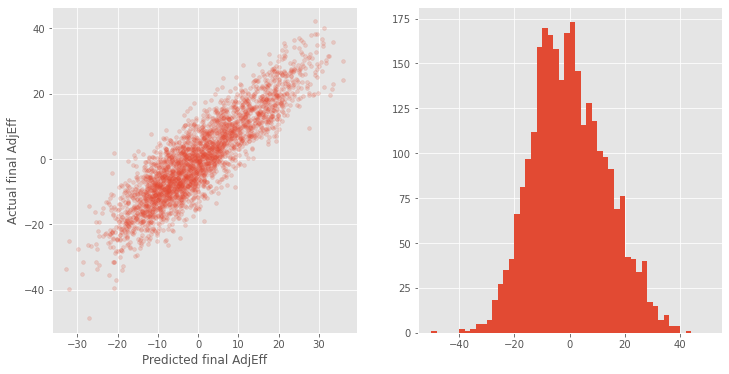

In [25]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].scatter(df.pred_eff, df.final_eff, alpha=0.2, s=15)
axs[0].set_xlabel('Predicted final AdjEff')
axs[0].set_ylabel('Actual final AdjEff')
# plt.scatter(df.recruit_score, df.final_eff-df.pred_eff, alpha=0.2)
axs[1].hist(df.final_eff, bins=np.linspace(-50,50,51))
print(np.mean(df.pred_eff))

['dummy', 'yearm2_eff', 'wshares_lost', 'wshares_transfer', 'recruit_score']
['yearm1_eff', 'dummy', 'wshares_lost', 'wshares_transfer', 'recruit_score']
['yearm1_eff', 'yearm2_eff', 'dummy', 'wshares_transfer', 'recruit_score']
['yearm1_eff', 'yearm2_eff', 'wshares_lost', 'dummy', 'recruit_score']
['yearm1_eff', 'yearm2_eff', 'wshares_lost', 'wshares_transfer', 'dummy']


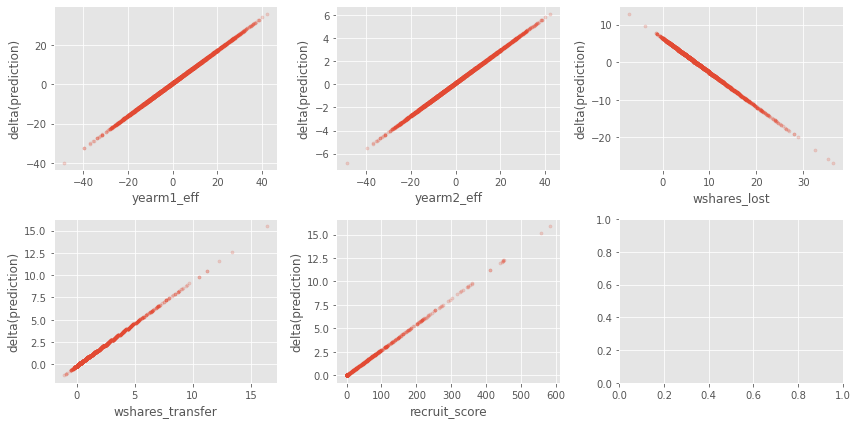

In [26]:
fig,axs = plt.subplots(2,3,figsize=(12,6))
axs = axs.flatten()
for i,c in enumerate(cols):
    df['dummy'] = df[c].median()
    cols_mod = list(cols)
    cols_mod[i] = 'dummy'
    print(cols_mod)
    X = df[cols]
    X_mod = df[cols_mod]
    pred = MODEL.predict(X.values)
    pred_mod = MODEL.predict(X_mod.values)
    axs[i].scatter(df[c], pred-pred_mod, alpha=0.2, s=10)
    axs[i].set_xlabel(c)
    axs[i].set_ylabel('delta(prediction)')
fig.tight_layout()

[0.6008146] 27.52525197019292


,year,tid,final_eff,yearm1_eff,yearm2_eff,wshares_lost,wshares_return,wshares_transfer,espn_recruit_rank,rsci_recruit_rank,rsci_recruit_points,yearm1_oeff,yearm1_deff,yearm1_pace,final_pace,recruit_score,pred_eff,dummy,pred_pace
0,2013,air-force,7.075949,-0.510858,5.814456,1.7,12.0,0.0,NaN,NaN,0,98.320187,98.831045,62.423965,64.534477,0,4.713164,0.0,65.030481
1,2013,akron,11.614801,11.358577,3.769233,6.0,15.8,0.0,NaN,NaN,0,105.444701,94.086124,68.663129,67.136842,0,10.372182,0.0,68.779062
2,2013,alabama,13.221202,18.569926,15.892420,7.8,14.9,0.0,NaN,25.0,79,104.865342,86.295416,63.448609,62.245498,79,18.504782,0.0,65.646102
3,2013,alabama-am,-24.748909,-24.829521,-16.968670,3.2,4.4,0.0,NaN,NaN,0,87.082021,111.911542,68.425847,66.737335,0,-20.146877,0.0,68.636500
4,2013,alabama-birmingham,-0.203764,4.770494,13.027349,7.0,7.1,0.0,NaN,NaN,0,98.948628,94.178134,62.798827,71.980181,0,5.310020,0.0,65.255704


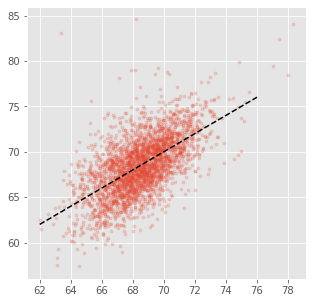

In [28]:
df_tmp = df[df.year != PREDICT_YEAR]
linreg.fit(df_tmp.yearm1_pace.values.reshape(-1,1), df_tmp.final_pace)
print(linreg.coef_, linreg.intercept_)
df["pred_pace"] = linreg.predict(df.yearm1_pace.values.reshape(-1,1))
plt.figure(figsize=(5,5))
plt.scatter(df.pred_pace, df.final_pace, alpha=0.2, s=10)
plt.plot([62,76], [62,76], 'k--')
df.head()

In [31]:
avg_eff = df.final_eff.mean()
frac_to_off = (df.yearm1_oeff - avg_eff).abs() / ((df.yearm1_oeff-avg_eff).abs() + (df.yearm1_deff-avg_eff).abs())
df["pred_oeff"] = df.yearm1_oeff + (df.pred_eff - df.yearm1_eff) * frac_to_off
df["pred_deff"] = df.yearm1_deff - (df.pred_eff - df.yearm1_eff) * (1-frac_to_off)
df.drop('dummy', axis=1).rename({'tid':'team_id'}, axis=1).to_csv('../data/preseason_predictions.csv', 
                                                                  float_format="%.3f",
                                                                  index=False)
df.head()

,year,tid,final_eff,yearm1_eff,yearm2_eff,wshares_lost,wshares_return,wshares_transfer,espn_recruit_rank,rsci_recruit_rank,...,dummy,pred_pace,pred_oeff,pred_deff,contrib_yearm1_eff,contrib_yearm2_eff,contrib_wshares_lost,contrib_wshares_transfer,contrib_recruit_score,intercept
0,2013,air-force,7.075949,-0.510858,5.814456,1.7,12.0,0.0,NaN,NaN,...,0.0,65.030481,100.925424,96.212260,-0.425616,0.826498,-1.550349,0.0,0.000000,5.77932
1,2013,akron,11.614801,11.358577,3.769233,6.0,15.8,0.0,NaN,NaN,...,0.0,68.779062,104.923406,94.551224,9.463268,0.535779,-5.471820,0.0,0.000000,5.77932
2,2013,alabama,13.221202,18.569926,15.892420,7.8,14.9,0.0,NaN,25.0,...,0.0,65.646102,104.829603,86.324821,15.471320,2.259035,-7.113366,0.0,2.152868,5.77932
3,2013,alabama-am,-24.748909,-24.829521,-16.968670,3.2,4.4,0.0,NaN,NaN,...,0.0,68.636500,89.130975,109.277852,-20.686429,-2.412019,-2.918304,0.0,0.000000,5.77932
4,2013,alabama-birmingham,-0.203764,4.770494,13.027349,7.0,7.1,0.0,NaN,NaN,...,0.0,65.255704,99.225059,93.915039,3.974482,1.851778,-6.383790,0.0,0.000000,5.77932


In [33]:
ps = []
for FRAC in np.arange(0.05,0.96,0.05):
    first, second = utils.partition_games(df_games, frac=FRAC)
    season_stats_dict = utils.compute_season_stats(df_games.iloc[first])
    season_stats_df = utils.stats_dict_to_df(season_stats_dict)
    utils.add_advanced_stats(season_stats_df)
    season_stats_dict = utils.stats_df_to_dict(season_stats_df)
    param = 0.9 + 0.1*min(0.2,FRAC)/0.2
    eff.compute_efficiency_ratings(season_stats_dict, conv_param=param)
    season_stats_df = utils.stats_dict_to_df(season_stats_dict)
    df_merge = df.merge(season_stats_df[['year','team_id','Tneteff','pace']], left_on=['year','tid'], right_on=['year','team_id'])
    df_merge = df_merge.loc[df_merge.Tneteff > -900]
    a = df_merge.pred_eff
    b = df_merge.Tneteff
    y = df_merge.final_eff
    p = -(a*b-b**2-a*y+b*y).sum() / ((a-b)**2).sum()
    a = df_merge.pred_pace
    b = df_merge.pace
    y = df_merge.final_pace
    p2 = -(a*b-b**2-a*y+b*y).sum() / ((a-b)**2).sum()
    print(f'{FRAC:.2f} {p:.3f} {p2:.3f}')
    ps.append((FRAC,p,p2))


0.05 0.881 0.808
0.10 0.807 0.732
0.15 0.664 0.628
0.20 0.553 0.537
0.25 0.462 0.467
0.30 0.389 0.407
0.35 0.311 0.357
0.40 0.263 0.307
0.45 0.215 0.261
0.50 0.175 0.218
0.55 0.143 0.177
0.60 0.110 0.144
0.65 0.085 0.114
0.70 0.072 0.087
0.75 0.055 0.065
0.80 0.039 0.049
0.85 0.026 0.032
0.90 0.013 0.019
0.95 0.007 0.007


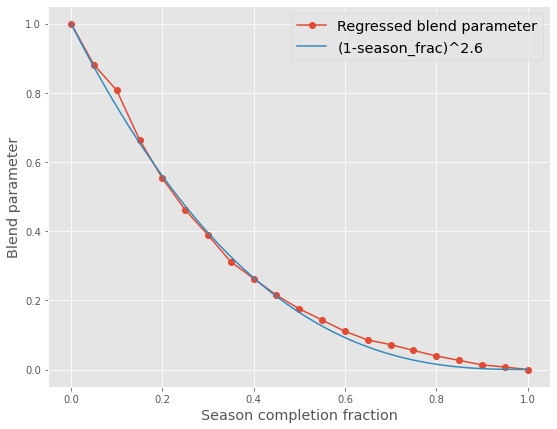

In [38]:
plt.figure(figsize=(9,7))
pvals = [x[1] for x in ps]
pvals_pace = [x[2] for x in ps]
xs = np.linspace(0,1,101)
ys = (1-xs)**2.6
plt.plot(np.arange(0,1.01,0.05), [1]+pvals+[0], 'o-', label='Regressed blend parameter')
plt.plot(xs, ys, '-', label='(1-season_frac)^2.6')
# plt.plot(np.arange(0,1.01,0.05), [1]+pvals_pace+[0], 'o-')
plt.xlabel('Season completion fraction', fontsize='x-large')
plt.ylabel('Blend parameter', fontsize='x-large')
plt.legend(fontsize='x-large')